# Experiment 10: Solving a Markov Decision Process (MDP)
# GridWorld Value Iteration Implementation

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict

# TASK 1: DEFINE THE GRIDWORLD (THE MDP)

In [3]:
## Task 1.1: Define States

# Grid dimensions
ROWS = 3
COLS = 4

# Define all valid states (excluding wall at (1,1))
states = []
for r in range(ROWS):
    for c in range(COLS):
        if (r, c) != (1, 1):  # Exclude wall
            states.append((r, c))

print(f"Total valid states: {len(states)}")
print(f"States: {states}")

# Define special states
WALL = (1, 1)
GOAL = (0, 3)
PIT = (1, 3)
TERMINAL_STATES = [GOAL, PIT]

print(f"\nSpecial states:")
print(f"Wall: {WALL}")
print(f"Goal: {GOAL}")
print(f"Pit: {PIT}")

Total valid states: 11
States: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]

Special states:
Wall: (1, 1)
Goal: (0, 3)
Pit: (1, 3)


In [4]:

## Task 1.2: Define Rewards

def get_reward(state: Tuple[int, int], living_penalty: float = -0.04) -> float:
    """
    Returns the reward for being in a state.
    
    Args:
        state: Current state (row, col)
        living_penalty: Penalty for each step (default: -0.04)
    
    Returns:
        Reward value
    """
    if state == GOAL:
        return 1.0
    elif state == PIT:
        return -1.0
    else:
        return living_penalty

# Test rewards
print("\nRewards:")
print(f"Goal {GOAL}: {get_reward(GOAL)}")
print(f"Pit {PIT}: {get_reward(PIT)}")
print(f"Normal state (0,0): {get_reward((0,0))}")

## Task 1.3: Define Discount Factor

GAMMA = 0.99
print(f"\nDiscount Factor (gamma): {GAMMA}")

## Task 1.4: Define Actions

ACTIONS = ['up', 'down', 'left', 'right']
print(f"\nAvailable Actions: {ACTIONS}")

## Task 1.5: Define Transition Model

def get_direction_deltas(action: str) -> Tuple[int, int]:
    """Returns the (row_delta, col_delta) for an action."""
    if action == 'up':
        return (-1, 0)
    elif action == 'down':
        return (1, 0)
    elif action == 'left':
        return (0, -1)
    elif action == 'right':
        return (0, 1)
    else:
        raise ValueError(f"Unknown action: {action}")

def get_perpendicular_actions(action: str) -> Tuple[str, str]:
    """Returns the (left_slip, right_slip) actions for a given action."""
    if action == 'up':
        return ('left', 'right')
    elif action == 'down':
        return ('right', 'left')
    elif action == 'left':
        return ('down', 'up')
    elif action == 'right':
        return ('up', 'down')

def is_valid_state(state: Tuple[int, int]) -> bool:
    """Check if a state is valid (within bounds and not a wall)."""
    r, c = state
    if r < 0 or r >= ROWS or c < 0 or c >= COLS:
        return False
    if state == WALL:
        return False
    return True

def get_next_state(current_state: Tuple[int, int], action: str) -> Tuple[int, int]:
    """
    Returns the next state after taking an action.
    If the move is invalid (wall or boundary), returns current state.
    """
    dr, dc = get_direction_deltas(action)
    next_state = (current_state[0] + dr, current_state[1] + dc)
    
    if is_valid_state(next_state):
        return next_state
    else:
        return current_state  # Stay in place if invalid move

def get_next_states(state: Tuple[int, int], action: str) -> List[Tuple[float, Tuple[int, int]]]:
    """
    Returns list of (probability, next_state) tuples for a given state and action.
    
    Stochastic transitions:
    - 80% chance: intended direction
    - 10% chance: 90 degrees left
    - 10% chance: 90 degrees right
    
    Args:
        state: Current state (row, col)
        action: Intended action
    
    Returns:
        List of (probability, next_state) tuples
    """
    # Terminal states have no transitions
    if state in TERMINAL_STATES:
        return [(1.0, state)]
    
    # Get the three possible movement directions
    intended_next = get_next_state(state, action)
    left_action, right_action = get_perpendicular_actions(action)
    left_next = get_next_state(state, left_action)
    right_next = get_next_state(state, right_action)
    
    # Collect transitions with probabilities
    transitions = {}
    transitions[intended_next] = transitions.get(intended_next, 0) + 0.8
    transitions[left_next] = transitions.get(left_next, 0) + 0.1
    transitions[right_next] = transitions.get(right_next, 0) + 0.1
    
    return [(prob, next_state) for next_state, prob in transitions.items()]

# Test transition model
print("\nTesting Transition Model:")
test_state = (0, 0)
test_action = 'right'
transitions = get_next_states(test_state, test_action)
print(f"From state {test_state}, action '{test_action}':")
for prob, next_state in transitions:
    print(f"  -> {next_state} with probability {prob}")


Rewards:
Goal (0, 3): 1.0
Pit (1, 3): -1.0
Normal state (0,0): -0.04

Discount Factor (gamma): 0.99

Available Actions: ['up', 'down', 'left', 'right']

Testing Transition Model:
From state (0, 0), action 'right':
  -> (0, 1) with probability 0.8
  -> (0, 0) with probability 0.1
  -> (1, 0) with probability 0.1


# TASK 2: VALUE ITERATION ALGORITHM

In [6]:
def value_iteration(states: List[Tuple[int, int]], 
                   gamma: float = 0.99, 
                   theta: float = 0.0001,
                   living_penalty: float = -0.04,
                   max_iterations: int = 1000) -> Dict[Tuple[int, int], float]:
    """
    Implements the Value Iteration algorithm to solve the MDP.
    
    Args:
        states: List of all valid states
        gamma: Discount factor
        theta: Convergence threshold
        living_penalty: Reward for non-terminal states
        max_iterations: Maximum number of iterations
    
    Returns:
        Dictionary mapping states to their values
    """
    # Initialize value function
    V = {state: 0.0 for state in states}
    
    iteration = 0
    
    while iteration < max_iterations:
        delta = 0  # Track maximum change in value
        V_new = V.copy()
        
        # Update value for each state
        for s in states:
            # Terminal states have value 0
            if s in TERMINAL_STATES:
                V_new[s] = 0.0
                continue
            
            # Calculate value for each action and take maximum
            action_values = []
            
            for action in ACTIONS:
                # Calculate expected value for this action
                # Q(s,a) = sum over s' of P(s'|s,a) * [R(s) + gamma * V(s')]
                q_value = 0.0
                transitions = get_next_states(s, action)
                
                for prob, next_state in transitions:
                    reward = get_reward(s, living_penalty)
                    q_value += prob * (reward + gamma * V[next_state])
                
                action_values.append(q_value)
            
            # Bellman optimality: take maximum over actions
            V_new[s] = max(action_values)
            
            # Track change
            delta = max(delta, abs(V_new[s] - V[s]))
        
        V = V_new
        iteration += 1
        
        # Check convergence
        if delta < theta:
            print(f"Value Iteration converged in {iteration} iterations (delta={delta:.6f})")
            break
    
    if iteration == max_iterations:
        print(f"Reached maximum iterations ({max_iterations})")
    
    return V



V_optimal = value_iteration(states, gamma=GAMMA, living_penalty=-0.04)

print("\nValue Iteration Complete!")


Value Iteration converged in 13 iterations (delta=0.000048)

Value Iteration Complete!


# TASK 3: POLICY EXTRACTION

In [8]:
def extract_policy(states: List[Tuple[int, int]], 
                  V: Dict[Tuple[int, int], float],
                  gamma: float = 0.99,
                  living_penalty: float = -0.04) -> Dict[Tuple[int, int], str]:
    """
    Extracts the optimal policy from the value function.
    
    Args:
        states: List of all valid states
        V: Value function (state -> value mapping)
        gamma: Discount factor
        living_penalty: Reward for non-terminal states
    
    Returns:
        Dictionary mapping states to optimal actions
    """
    policy = {}
    
    for s in states:
        # Terminal states have no actions
        if s in TERMINAL_STATES:
            policy[s] = None
            continue
        
        # Calculate Q-value for each action
        best_action = None
        best_value = float('-inf')
        
        for action in ACTIONS:
            # Calculate Q(s,a) = sum over s' of P(s'|s,a) * [R(s) + gamma * V(s')]
            q_value = 0.0
            transitions = get_next_states(s, action)
            
            for prob, next_state in transitions:
                reward = get_reward(s, living_penalty)
                q_value += prob * (reward + gamma * V[next_state])
            
            # Track best action
            if q_value > best_value:
                best_value = q_value
                best_action = action
        
        policy[s] = best_action
    
    return policy

print("Extracting Optimal Policy...")

policy_optimal = extract_policy(states, V_optimal, gamma=GAMMA, living_penalty=-0.04)

print("\nPolicy Extraction Complete!")

Extracting Optimal Policy...

Policy Extraction Complete!


# TASK 4: VISUALIZATION AND ANALYSIS

In [9]:
def visualize_value_function(V: Dict[Tuple[int, int], float], title: str = "Value Function"):
    """Visualizes the value function as a heatmap."""
    # Create grid for visualization
    grid = np.zeros((ROWS, COLS))
    
    for r in range(ROWS):
        for c in range(COLS):
            if (r, c) == WALL:
                grid[r, c] = np.nan  # Wall shown as white/empty
            elif (r, c) in V:
                grid[r, c] = V[(r, c)]
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(grid, annot=True, fmt='.3f', cmap='RdYlGn', 
                cbar_kws={'label': 'State Value'}, 
                linewidths=2, linecolor='black',
                vmin=-1, vmax=1)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Row', fontsize=12)
    
    # Add labels for special states
    plt.text(3.5, 0.5, 'GOAL\n(+1)', ha='center', va='center', 
             fontweight='bold', fontsize=10, color='darkgreen')
    plt.text(3.5, 1.5, 'PIT\n(-1)', ha='center', va='center', 
             fontweight='bold', fontsize=10, color='darkred')
    plt.text(1.5, 1.5, 'WALL', ha='center', va='center', 
             fontweight='bold', fontsize=10, color='gray')
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Task 4.2: Visualize Policy

def visualize_policy(policy: Dict[Tuple[int, int], str], title: str = "Optimal Policy"):
    """Visualizes the policy as arrows on a grid."""
    # Create grid for visualization
    grid = np.zeros((ROWS, COLS))
    
    # Arrow symbols
    arrow_map = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→',
        None: '·'
    }
    
    # Create annotation grid
    annot_grid = []
    for r in range(ROWS):
        row = []
        for c in range(COLS):
            if (r, c) == WALL:
                row.append('WALL')
                grid[r, c] = np.nan
            elif (r, c) == GOAL:
                row.append('GOAL')
                grid[r, c] = 1
            elif (r, c) == PIT:
                row.append('PIT')
                grid[r, c] = -1
            elif (r, c) in policy:
                row.append(arrow_map[policy[(r, c)]])
                grid[r, c] = 0
            else:
                row.append('')
                grid[r, c] = 0
        annot_grid.append(row)
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(grid, annot=np.array(annot_grid), fmt='', 
                cmap='coolwarm', cbar=False,
                linewidths=2, linecolor='black',
                annot_kws={'fontsize': 20, 'fontweight': 'bold'})
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Row', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def print_grid_values(V: Dict[Tuple[int, int], float]):
    """Prints value function in grid format."""
    print("\nValue Function (Grid Format):")
    print("-" * 50)
    for r in range(ROWS):
        row_str = ""
        for c in range(COLS):
            if (r, c) == WALL:
                row_str += "  WALL  "
            elif (r, c) in V:
                row_str += f"{V[(r, c)]:7.3f}"
            else:
                row_str += "   -   "
            row_str += " | "
        print(row_str)
        print("-" * 50)

def print_grid_policy(policy: Dict[Tuple[int, int], str]):
    """Prints policy in grid format."""
    arrow_map = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→', None: '·'}
    
    print("\nOptimal Policy (Grid Format):")
    print("-" * 40)
    for r in range(ROWS):
        row_str = ""
        for c in range(COLS):
            if (r, c) == WALL:
                row_str += " WALL "
            elif (r, c) == GOAL:
                row_str += " GOAL "
            elif (r, c) == PIT:
                row_str += " PIT  "
            elif (r, c) in policy:
                arrow = arrow_map.get(policy[(r, c)], '?')
                row_str += f"  {arrow}   "
            else:
                row_str += "  -   "
            row_str += " | "
        print(row_str)
        print("-" * 40)

QUESTION 1: DEFAULT PARAMETERS (Living Penalty = -0.04)

Value Function (Grid Format):
--------------------------------------------------
 -0.154 |  -0.100 |  -0.050 |   0.000 | 
--------------------------------------------------
 -0.202 |   WALL   |  -0.055 |   0.000 | 
--------------------------------------------------
 -0.196 |  -0.148 |  -0.099 |  -0.055 | 
--------------------------------------------------

Optimal Policy (Grid Format):
----------------------------------------
  →    |   →    |   →    |  GOAL  | 
----------------------------------------
  ↑    |  WALL  |   →    |  PIT   | 
----------------------------------------
  →    |   →    |   →    |   ↑    | 
----------------------------------------


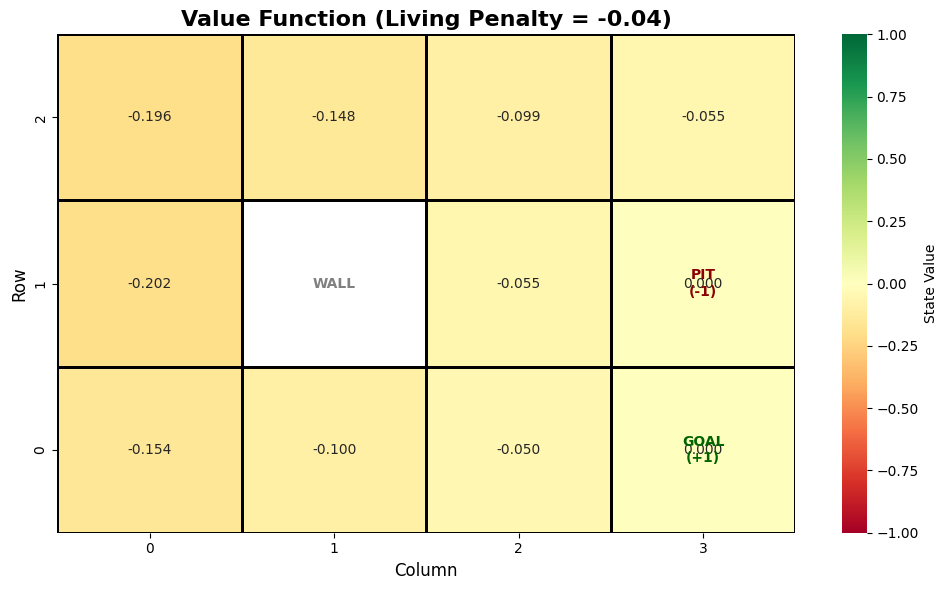

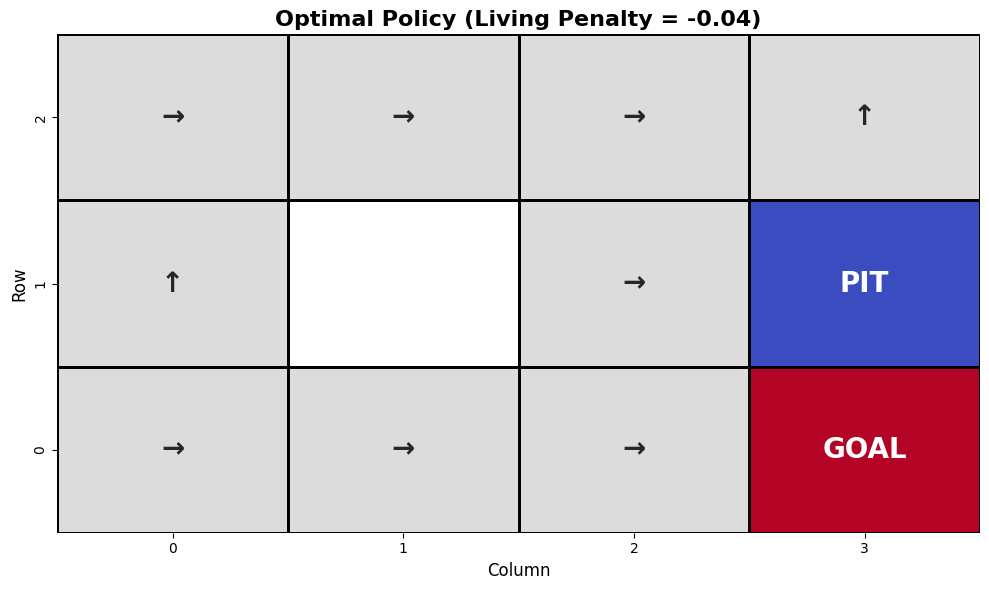


Analysis:
The policy makes sense! The agent:
- Moves toward the GOAL at (0,3)
- Avoids the PIT at (1,3)
- Takes the safer path through the top row when near the pit
- The living penalty encourages finding the shortest path
QUESTION 2: NO LIVING PENALTY (Living Penalty = 0.0)
Value Iteration converged in 1 iterations (delta=0.000000)

Value Function (Grid Format):
--------------------------------------------------
  0.000 |   0.000 |   0.000 |   0.000 | 
--------------------------------------------------
  0.000 |   WALL   |   0.000 |   0.000 | 
--------------------------------------------------
  0.000 |   0.000 |   0.000 |   0.000 | 
--------------------------------------------------

Optimal Policy (Grid Format):
----------------------------------------
  ↑    |   ↑    |   ↑    |  GOAL  | 
----------------------------------------
  ↑    |  WALL  |   ↑    |  PIT   | 
----------------------------------------
  ↑    |   ↑    |   ↑    |   ↑    | 
----------------------------------------

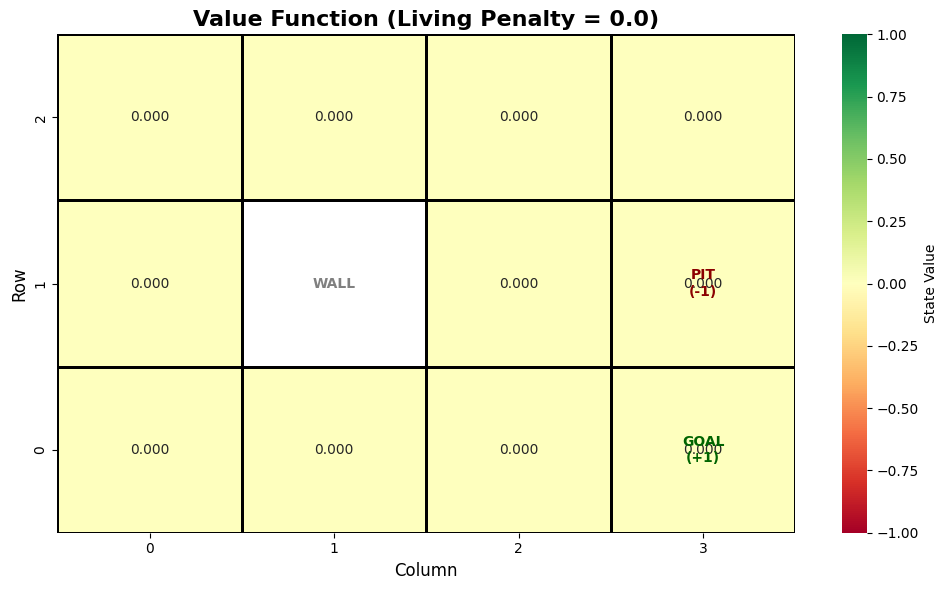

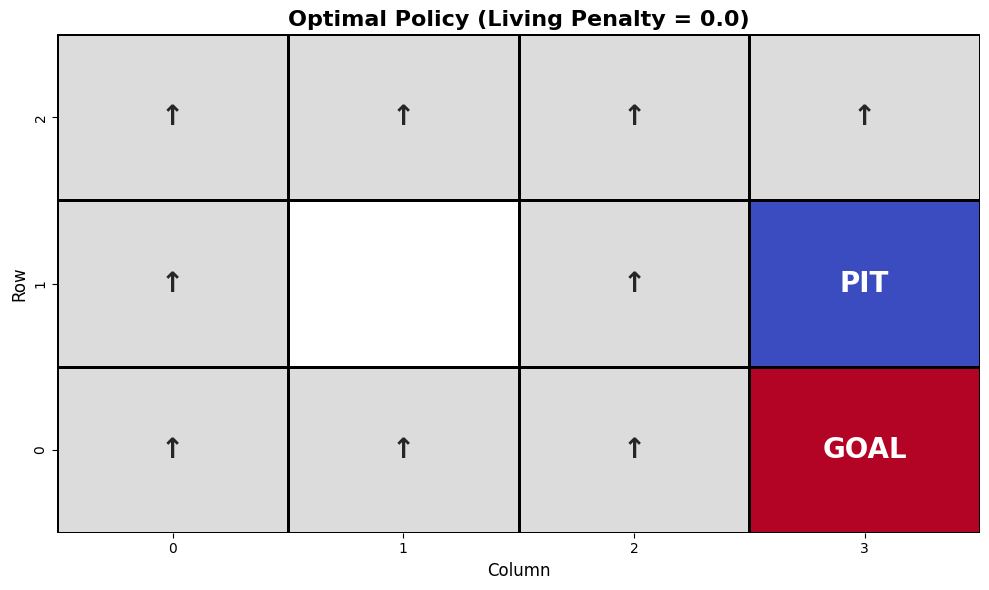


Analysis:
With no living penalty (R = 0.0):
- The agent is not penalized for taking longer paths
- The policy may show less urgency to reach the goal quickly
- The agent might take safer, longer routes since there's no cost for extra steps
- States far from the goal have higher values compared to the default case
QUESTION 3: HIGH LIVING PENALTY (Living Penalty = -0.5)
Value Iteration converged in 16 iterations (delta=0.000052)

Value Function (Grid Format):
--------------------------------------------------
 -1.928 |  -1.246 |  -0.630 |   0.000 | 
--------------------------------------------------
 -2.527 |   WALL   |  -0.685 |   0.000 | 
--------------------------------------------------
 -2.455 |  -1.846 |  -1.238 |  -0.691 | 
--------------------------------------------------

Optimal Policy (Grid Format):
----------------------------------------
  →    |   →    |   →    |  GOAL  | 
----------------------------------------
  ↑    |  WALL  |   →    |  PIT   | 
----------------------

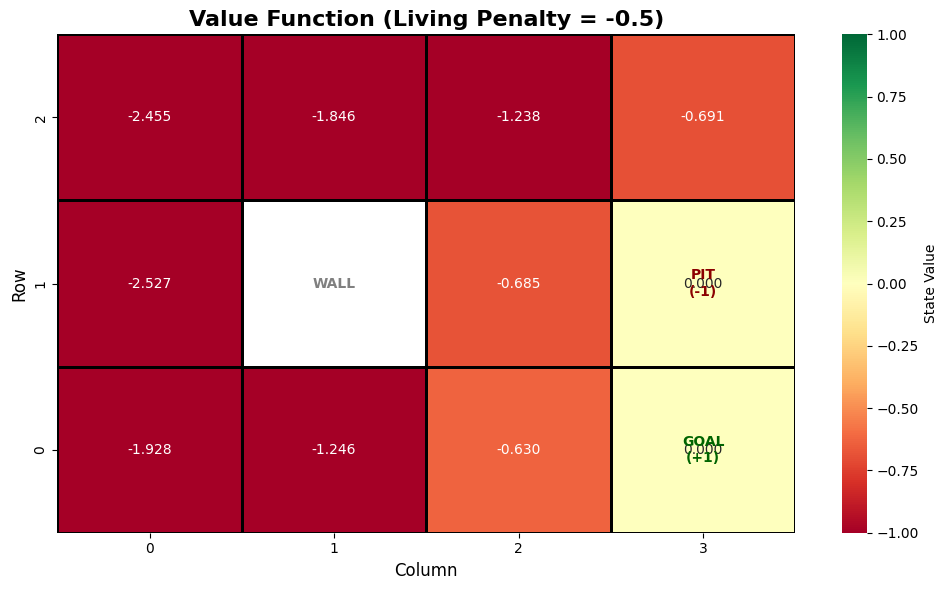

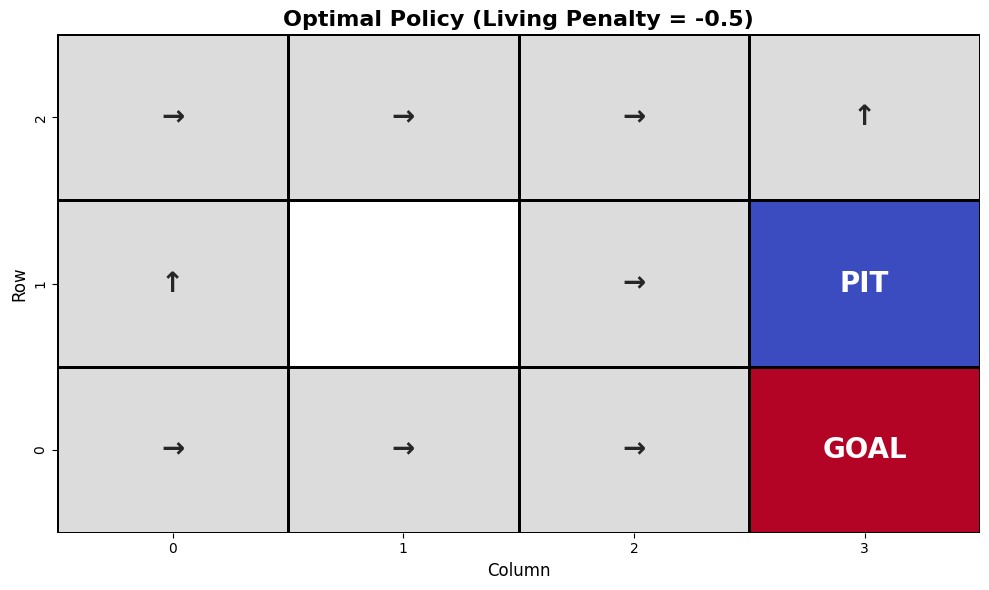


Analysis:
With high living penalty (R = -0.5):
- The agent is heavily penalized for each step taken
- The agent may take riskier, shorter paths even near the pit
- In extreme cases, the agent might prefer the pit (-1) over a long path
- Values are much lower overall due to the high step cost
- The policy prioritizes speed over safety
SUMMARY: IMPACT OF LIVING PENALTY ON BEHAVIOR

Living Penalty Trade-offs:

1. R = -0.04 (Default):
   - Balanced behavior: shortest safe path
   - Agent values both safety and efficiency

2. R = 0.0 (No Penalty):
   - Agent can wander without cost
   - Takes safest paths regardless of length
   - Higher state values overall

3. R = -0.5 (High Penalty):
   - Desperate to reach terminal state quickly
   - May risk falling into pit to avoid step costs
   - Much lower state values
   - Shortest path at any cost

The living penalty is crucial for shaping agent behavior!



In [10]:
## Question 1: Default Parameters (R = -0.04)

print("QUESTION 1: DEFAULT PARAMETERS (Living Penalty = -0.04)")


print_grid_values(V_optimal)
print_grid_policy(policy_optimal)

visualize_value_function(V_optimal, "Value Function (Living Penalty = -0.04)")
visualize_policy(policy_optimal, "Optimal Policy (Living Penalty = -0.04)")

print("\nAnalysis:")
print("The policy makes sense! The agent:")
print("- Moves toward the GOAL at (0,3)")
print("- Avoids the PIT at (1,3)")
print("- Takes the safer path through the top row when near the pit")
print("- The living penalty encourages finding the shortest path")

## Question 2: No Living Penalty (R = 0.0)

print("QUESTION 2: NO LIVING PENALTY (Living Penalty = 0.0)")

V_no_penalty = value_iteration(states, gamma=GAMMA, living_penalty=0.0)
policy_no_penalty = extract_policy(states, V_no_penalty, gamma=GAMMA, living_penalty=0.0)

print_grid_values(V_no_penalty)
print_grid_policy(policy_no_penalty)

visualize_value_function(V_no_penalty, "Value Function (Living Penalty = 0.0)")
visualize_policy(policy_no_penalty, "Optimal Policy (Living Penalty = 0.0)")

print("\nAnalysis:")
print("With no living penalty (R = 0.0):")
print("- The agent is not penalized for taking longer paths")
print("- The policy may show less urgency to reach the goal quickly")
print("- The agent might take safer, longer routes since there's no cost for extra steps")
print("- States far from the goal have higher values compared to the default case")

## Question 3: High Living Penalty (R = -0.5)


print("QUESTION 3: HIGH LIVING PENALTY (Living Penalty = -0.5)")

V_high_penalty = value_iteration(states, gamma=GAMMA, living_penalty=-0.5)
policy_high_penalty = extract_policy(states, V_high_penalty, gamma=GAMMA, living_penalty=-0.5)

print_grid_values(V_high_penalty)
print_grid_policy(policy_high_penalty)

visualize_value_function(V_high_penalty, "Value Function (Living Penalty = -0.5)")
visualize_policy(policy_high_penalty, "Optimal Policy (Living Penalty = -0.5)")

print("\nAnalysis:")
print("With high living penalty (R = -0.5):")
print("- The agent is heavily penalized for each step taken")
print("- The agent may take riskier, shorter paths even near the pit")
print("- In extreme cases, the agent might prefer the pit (-1) over a long path")
print("- Values are much lower overall due to the high step cost")
print("- The policy prioritizes speed over safety")

## Summary Comparison

print("SUMMARY: IMPACT OF LIVING PENALTY ON BEHAVIOR")

print("""
Living Penalty Trade-offs:

1. R = -0.04 (Default):
   - Balanced behavior: shortest safe path
   - Agent values both safety and efficiency
   
2. R = 0.0 (No Penalty):
   - Agent can wander without cost
   - Takes safest paths regardless of length
   - Higher state values overall
   
3. R = -0.5 (High Penalty):
   - Desperate to reach terminal state quickly
   - May risk falling into pit to avoid step costs
   - Much lower state values
   - Shortest path at any cost

The living penalty is crucial for shaping agent behavior!
""")